In [1]:
import gzip
import os
import shutil

dir_path = './images/metadata'
input_file = os.path.join(dir_path, "images.csv.gz")
output_file = os.path.join(dir_path, "images.csv")

with gzip.open(input_file, "rb") as f_in:
    with open(output_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Extraction complete: {output_file}")


Extraction complete: ./images/metadata/images.csv


In [2]:
import polars as pl


def extract_image_paths_from_csv(file_path: str = './images/metadata/images.csv', min_image_width: int = 1000,
                                 min_image_height: int = 1000) -> list[str]:
    df = pl.read_csv(file_path)
    images_valid_paths = (
        df.filter((pl.col('width') >= min_image_width) &
                  (pl.col('height') >= min_image_height))
            .select(pl.col('path'))
        .to_pandas()
    )

    return images_valid_paths['path']


images_paths = extract_image_paths_from_csv()
print("Number of images:", len(images_paths))

Number of images: 342878


In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('clip-ViT-B-32')

text_emb = model.encode("A photo of a cat")
print("Text embedding shape:", text_emb.shape)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Text embedding shape: (512,)


| Part     | Meaning                                  | Explanation                                                                                                                                                                                      |
| -------- | ---------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **ViT**  | *Vision Transformer*                     | This is the *type of image encoder* used — a Transformer architecture applied to image patches instead of tokens.                                                                                |
| **B**    | *Base model size*                        | Indicates the model’s capacity — **B** stands for **Base**. Other sizes include **S (Small)**, **L (Large)**, etc.                                                                               |
| **32**   | *Patch size* (in pixels)                 | Each image is split into non-overlapping **32×32 patches** before being processed by the Transformer. Smaller patch sizes (e.g., 16) mean more patches → higher resolution but more computation. |


In [4]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db"
)

engine = create_engine(db_url)

In [7]:
from typing import List
from pgvector.sqlalchemy import Vector
from sqlalchemy import String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column


class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    __table_args__ = {'extend_existing': True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))


# Create table
Base.metadata.create_all(engine)

In [8]:
import joblib
from itertools import batched
from PIL import Image
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session

MAX_IMAGES = min(90000, len(images_paths))
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def insert_images(engine, images):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine, model, image_paths):
    dir = 'images/small/'
    processed_count = 0

    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(image_paths, BATCH_SIZE):  # finish (suggestion - use `batched`)

            if processed_count >= MAX_IMAGES:
                break

            remaining = MAX_IMAGES - processed_count
            if len(images_paths_batch) > remaining:
                images_paths_batch = images_paths_batch[:remaining]

            images = [Image.open(dir + path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            imgs = [Img(image_path=path, embedding=embedding)
                    for path, embedding in zip(images_paths_batch, embeddings)]

            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            processed_count += len(imgs)
            pbar.update(len(imgs))


vectorize_images(engine, model, images_paths)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
import matplotlib.pyplot as plt
from sqlalchemy import select

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        image_paths = ['images/small/' + img.image_path for img in found_images]
        self.display_images(image_paths, k)

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description) # calculate embedding of image_description

        # remember about session and commit
        query = (
            select(Img)
            .order_by(Img.embedding.cosine_distance(image_embedding))
            .limit(k)
        )
        with Session(self.engine) as session:
            result = session.execute(query).scalars().all() # execute query
        return result

    def display_images(self, images, k):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")

        plt.show()

In [23]:
searcher = ImageSearch(engine, model)

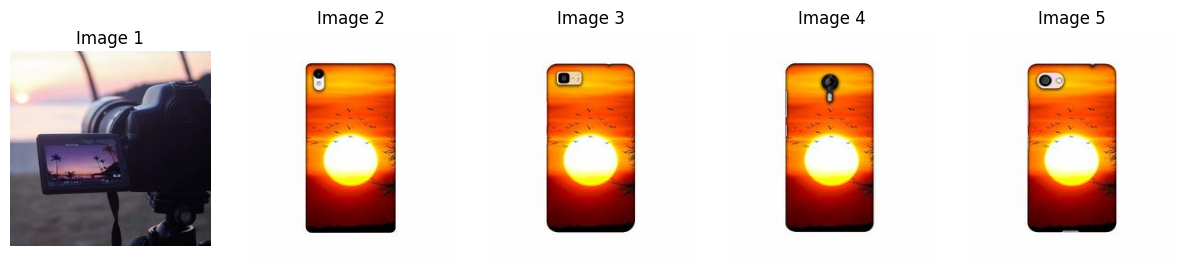

In [24]:
searcher("a sunset over the ocean", 5)

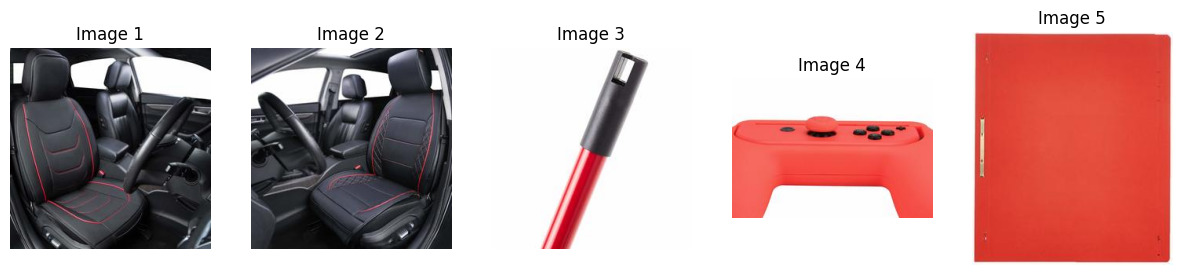

In [25]:
searcher("a red sports car", 5)

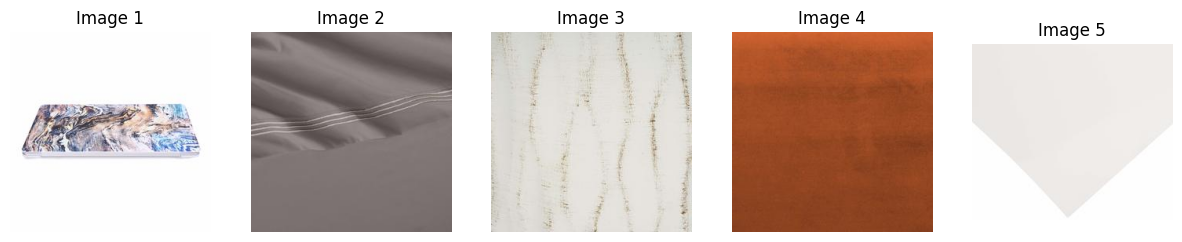

In [26]:
searcher("a mountain landscape", 5)

Yes, with larger datasets results generally improve. More data provides a richer variety of images, allowing the model to find closer matches to diverse queries.